<a href="https://colab.research.google.com/github/xwu23-max/QM2-Project/blob/main/Traffic_Intensity%26Air_PollutionTraffic_Intensity%26Air_Pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

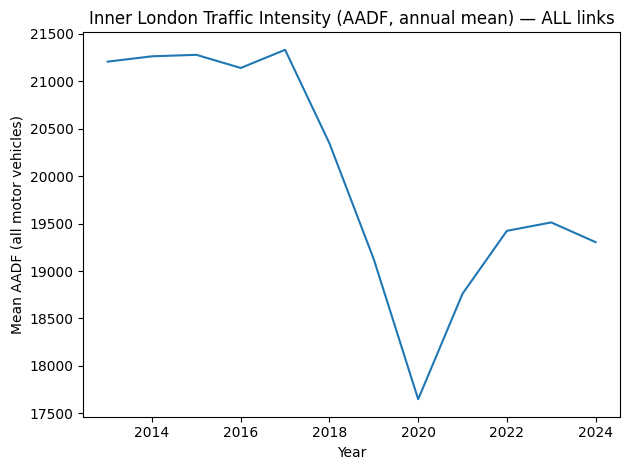

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Inner London AADF (ALL links)

# 1) DfT AADF road-link dataset
PATH = "dft_aadf_region_id_6.csv"
df = pd.read_csv(PATH)

# 2) Basic cleaning: ensure numeric types
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["all_motor_vehicles"] = pd.to_numeric(df["all_motor_vehicles"], errors="coerce")

# Drop rows missing year or AADF
df = df.dropna(subset=["year", "all_motor_vehicles"]).copy()
df["year"] = df["year"].astype(int)

# 3) Define Inner London boroughs (common definition)
INNER_LONDON = {
    "Camden", "Greenwich", "Hackney", "Hammersmith and Fulham", "Islington",
    "Kensington and Chelsea", "Lambeth", "Lewisham", "Southwark", "Tower Hamlets",
    "Wandsworth", "Westminster", "City of London"
}

# 4) Filter to Inner London
BOROUGH_COL = "local_authority_name"
if BOROUGH_COL not in df.columns:
    raise KeyError(
        f"Expected column '{BOROUGH_COL}' not found. "
        f"Available columns: {list(df.columns)}"
    )

inner = df[df[BOROUGH_COL].isin(INNER_LONDON)].copy()

# 5) Aggregate to annual mean AADF across Inner London (ALL links)
annual = (
    inner.groupby("year", as_index=False)
         .agg(
             mean_aadf=("all_motor_vehicles", "mean"),
             median_aadf=("all_motor_vehicles", "median"),
             n_links=("all_motor_vehicles", "count"),
         )
         .sort_values("year")
)

# 6) Restrict to study period
annual = annual[(annual["year"] >= 2013) & (annual["year"] <= 2025)].copy()

# 7) Save annual table
annual.to_csv("inner_london_aadf_all_links_annual_2013_2025.csv", index=False)

# 8) Plot (simple)
plt.figure()
plt.plot(annual["year"], annual["mean_aadf"])
plt.xlabel("Year")
plt.ylabel("Mean AADF (all motor vehicles)")
plt.title("Inner London Traffic Intensity (AADF, annual mean) — ALL links")
plt.tight_layout()
plt.savefig("traffic_intensity_inner_london_all_links.png", dpi=200)
plt.show()

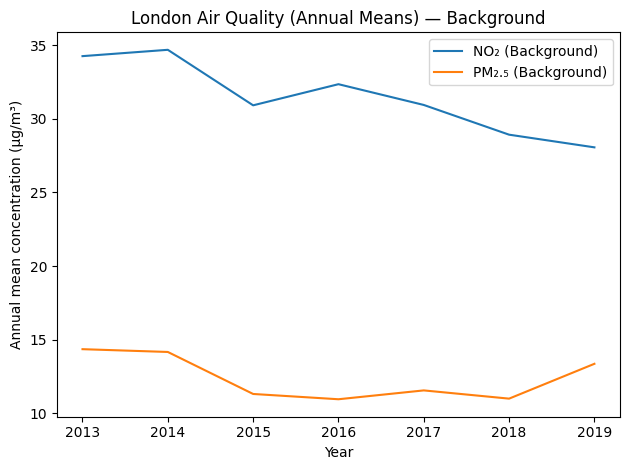

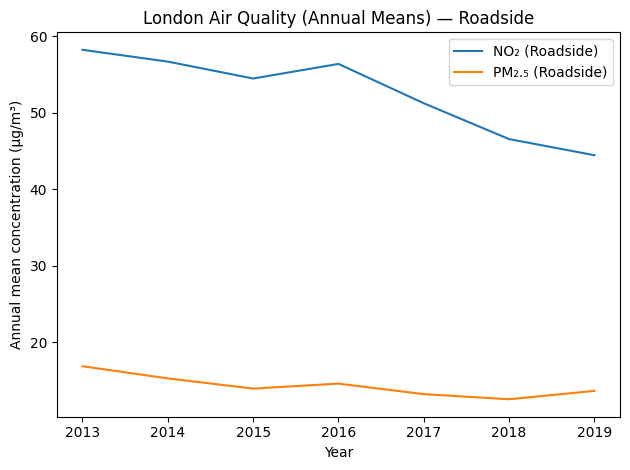

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load data
PATH = "air-quality-london-monthly-averages.csv"
df = pd.read_csv(PATH)

# 2) Parse dates
# Assumes Month column looks like "Jan-13", "Feb-13", etc.
df["Month"] = pd.to_datetime(df["Month"], format="%b-%y", errors="coerce")
df = df.dropna(subset=["Month"]).copy()
df["Year"] = df["Month"].dt.year

# 3) Columns
COLS = {
    "NO2_Background": "London Mean Background:Nitrogen Dioxide (ug/m3)",
    "PM25_Background": "London Mean Background:PM2.5 Particulate (ug/m3)",
    "NO2_Roadside": "London Mean Roadside:Nitrogen Dioxide (ug/m3)",
    "PM25_Roadside": "London Mean Roadside:PM2.5 Particulate (ug/m3)",
}

missing = [v for v in COLS.values() if v not in df.columns]
if missing:
    raise ValueError(
        "Missing expected columns:\n"
        + "\n".join(missing)
        + "\n\nAvailable columns:\n"
        + "\n".join(df.columns)
    )

# Ensure numeric
for new_name, old_name in COLS.items():
    df[new_name] = pd.to_numeric(df[old_name], errors="coerce")

# 4) Compute annual means
annual = (
    df.groupby("Year")[list(COLS.keys())]
      .mean(numeric_only=True)
      .reset_index()
      .sort_values("Year")
)

annual = annual[(annual["Year"] >= 2013) & (annual["Year"] <= 2025)].copy()

annual.to_csv("london_annual_means_no2_pm25_2013_2025.csv", index=False)

# 5) Plot: Background
plt.figure()
plt.plot(annual["Year"], annual["NO2_Background"], label="NO₂ (Background)")
plt.plot(annual["Year"], annual["PM25_Background"], label="PM₂.₅ (Background)")
plt.xlabel("Year")
plt.ylabel("Annual mean concentration (µg/m³)")
plt.title("London Air Quality (Annual Means) — Background")
plt.legend()
plt.tight_layout()
plt.savefig("london_annual_bg_no2_pm25_2013_2025.png", dpi=200)
plt.show()

# 6) Plot: Roadside
plt.figure()
plt.plot(annual["Year"], annual["NO2_Roadside"], label="NO₂ (Roadside)")
plt.plot(annual["Year"], annual["PM25_Roadside"], label="PM₂.₅ (Roadside)")
plt.xlabel("Year")
plt.ylabel("Annual mean concentration (µg/m³)")
plt.title("London Air Quality (Annual Means) — Roadside")
plt.legend()
plt.tight_layout()
plt.savefig("london_annual_roadside_no2_pm25_2013_2025.png", dpi=200)
plt.show()

/tmp/ipython-input-3032789136.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ti_wmean = tr_clean.groupby("year").apply(weighted_mean).reset_index().rename(columns={0:"TI_weighted_mean"})
/tmp/ipython-input-3032789136.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ti_total = tr_clean.groupby("year").apply(lambda g: np.sum(g[AADF_COL]*g[LEN_COL])).reset_index().rename(columns={0:"TI_total_vkm_prox


OLS: NO2 ~ TI_weighted_mean
                            OLS Regression Results                            
Dep. Variable:               NO2_mean   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                 -0.108
Method:                 Least Squares   F-statistic:                    0.5138
Date:                Mon, 12 Jan 2026   Prob (F-statistic):              0.513
Time:                        15:56:52   Log-Likelihood:                -17.986
No. Observations:                   6   AIC:                             39.97
Df Residuals:                       4   BIC:                             39.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const      

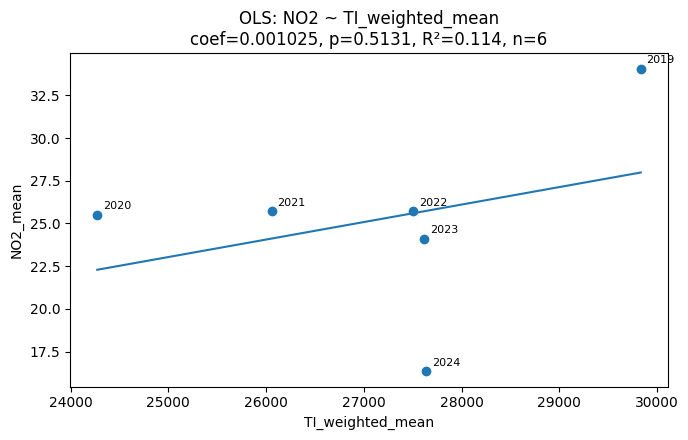


OLS: PM2.5 ~ TI_weighted_mean
                            OLS Regression Results                            
Dep. Variable:              PM25_mean   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                 -0.190
Method:                 Least Squares   F-statistic:                    0.2022
Date:                Mon, 12 Jan 2026   Prob (F-statistic):              0.676
Time:                        15:56:52   Log-Likelihood:                -10.904
No. Observations:                   6   AIC:                             25.81
Df Residuals:                       4   BIC:                             25.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const    

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


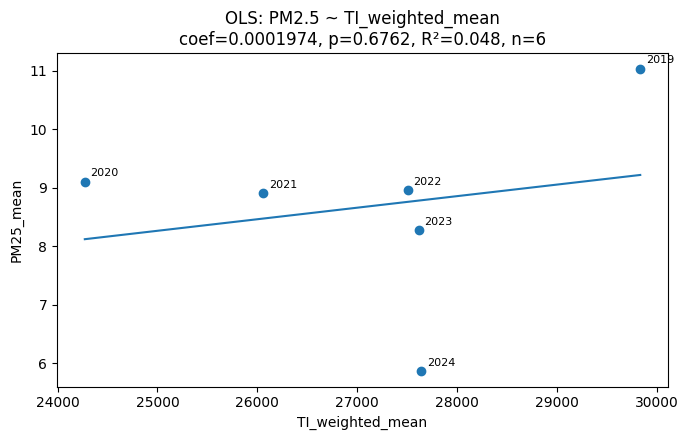

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

tr = pd.read_csv("dft_aadf_region_id_6.csv")
nit = pd.read_csv("Nitrogen.csv")
pm  = pd.read_csv("Pm2.5 (2).csv")

def parse_ukair_wide_to_yearly_mean(df, out_col_name):
    first_col = df.columns[0]
    header_idx = df.index[df[first_col].astype(str).str.strip().eq("Date")]
    if len(header_idx) == 0:
        raise ValueError("Cannot find header row 'Date'.")
    header_i = header_idx[0]
    site_i = 2

    data = df.iloc[header_i+1:].copy()

    sites = []
    for j in range(1, df.shape[1], 2):
        if j + 1 < df.shape[1]:
            s = df.iloc[site_i, j]
            sites.append(str(s) if (s is not None and str(s) != "nan") else f"Site_{len(sites)+1}")

    cols = ["Date"]
    for s in sites:
        cols.append(s)
        cols.append(f"{s}_status")

    data = data.iloc[:, :len(cols)]
    data.columns = cols

    data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
    data = data.dropna(subset=["Date"])
    data["year"] = data["Date"].dt.year

    site_cols = [c for c in data.columns if c not in ["Date", "year"] and not c.endswith("_status")]
    for c in site_cols:
        data[c] = pd.to_numeric(data[c], errors="coerce")

    data["daily_mean_across_sites"] = data[site_cols].mean(axis=1, skipna=True)
    yearly = (
        data.groupby("year")["daily_mean_across_sites"]
        .mean()
        .reset_index()
        .rename(columns={"daily_mean_across_sites": out_col_name})
    )
    return yearly

no2_year  = parse_ukair_wide_to_yearly_mean(nit, "NO2_mean")
pm25_year = parse_ukair_wide_to_yearly_mean(pm,  "PM25_mean")

AADF_COL = "all_motor_vehicles"
LEN_COL  = "link_length_km"

tr[AADF_COL] = pd.to_numeric(tr[AADF_COL], errors="coerce")
tr[LEN_COL]  = pd.to_numeric(tr[LEN_COL], errors="coerce")

tr_clean = tr.dropna(subset=["year", AADF_COL, LEN_COL]).copy()

ti_mean = tr_clean.groupby("year")[AADF_COL].mean().reset_index().rename(columns={AADF_COL:"TI_mean"})

def weighted_mean(g):
    return np.sum(g[AADF_COL]*g[LEN_COL]) / np.sum(g[LEN_COL])

ti_wmean = tr_clean.groupby("year").apply(weighted_mean).reset_index().rename(columns={0:"TI_weighted_mean"})

ti_total = tr_clean.groupby("year").apply(lambda g: np.sum(g[AADF_COL]*g[LEN_COL])).reset_index().rename(columns={0:"TI_total_vkm_proxy"})

ti = ti_mean.merge(ti_wmean, on="year").merge(ti_total, on="year")

df_no2 = no2_year.merge(ti, on="year", how="inner").sort_values("year")
df_pm  = pm25_year.merge(ti, on="year", how="inner").sort_values("year")


def ols_and_plot(df, y_col, x_col, title):
    d = df[["year", x_col, y_col]].dropna().copy()
    if len(d) < 3:
        print(f"{title}: not enough data, n={len(d)}")
        return

    X = sm.add_constant(d[x_col])
    y = d[y_col]
    model = sm.OLS(y, X).fit()

    print("\n" + "="*90)
    print(title)
    print(model.summary())

    plt.figure(figsize=(7,4.5))
    plt.scatter(d[x_col], d[y_col])
    for _, r in d.iterrows():
        plt.annotate(int(r["year"]), (r[x_col], r[y_col]), fontsize=8,
                     xytext=(4,4), textcoords="offset points")

    xx = np.linspace(d[x_col].min(), d[x_col].max(), 100)
    yy = model.params["const"] + model.params[x_col]*xx
    plt.plot(xx, yy)

    p = model.pvalues.get(x_col, np.nan)
    plt.title(f"{title}\ncoef={model.params[x_col]:.4g}, p={p:.4g}, R²={model.rsquared:.3f}, n={len(d)}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

XCOL = "TI_weighted_mean"

ols_and_plot(df_no2, "NO2_mean",  XCOL, f"OLS: NO2 ~ {XCOL}")
ols_and_plot(df_pm,  "PM25_mean", XCOL, f"OLS: PM2.5 ~ {XCOL}")